# Введение в трансформеры
## Attention Is All You Need
https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

In [2]:
import numpy as np

## Введение: задача перевода

Пусть перед нами стоит следующая абстрактная задача:
- есть два "пространства признаков" для каких-то объектов: пространство "запросов" и пространство "ответов"
- нам передан словарь примеров соответствия, т.е. набор пар векторов **Key**-**Value**, где **Key** - вектор из "запросов", а **Value** - вектор из "ответов"
- нам передан набор **Query** - вектора из пространства "запросов"

**Задача**: перевести **Query** в пространство "ответов"

### Конкретный пример: перевод с русского на английский

- есть две word2vec модели: `MR`, которая умеет для любого слова из **русского** языка строить вектор размерности 256 ("пространство запросов") и word2vec модель `MA`, которая умеет для любого слова из **английского** языка строить вектор размерности 128 ("пространство ответов")
- нам дали датасеты пар слов (русско-английский словарь) и датасеты пар текстов (книги и статьи, каждая в двух переводах) - для всех слов посчитали через MA и MR признаки (**Key**-**Value**)
- нам дали предложение на русском, и мы посчитали через MR вектора-признаки каждого слова (**Query**)
**Задача**: перевести предложение с русского на английский. 


![img](images/projections.png)

Можно представилять себе задачу, как поиск связи (отображения) между проекциями какого-то сложного многомерного объекта.

Связь существует (иначе ее было бы не найти), но может быть сложной.

## Формулировка dot-product attention

Пусть у нас есть три набора векторов (токенов, embedding-ов):
- Keys(K): матрица размера \[Nk, Dk\]
- Values(V): матрица размера \[Nk, Dv\]
- Query(Q): матрица размера \[Nq, Dk\]


![img](images/attention_formula.png)


![img](images/attention_scheme.png)

Tadaa!
Как утверждают авторы - это все что нам надо для решения (любой) задачи.
<hr>

## Какая размерность у Attention?

Размерность аргумента softmax ("energy"):

### $S = Q [Nq, Dk] @ K.T [Dk, Nk] = S[Nq, Nk]$

***Вопрос:*** Вдоль какой оси (осей?) нужно выполнять softmax для матрицы S?

Размерность attention:

### $A = S[Nq, Nk] @ V [Nk, Dv] = A[Nq, Dv]$

In [3]:
np.random.seed(42)


def softmax(x, axis):
    x_stable = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x_stable) / np.sum(np.exp(x_stable), axis=axis, keepdims=True)

def generate_kvq(Nk=10, Dk=16, Dv=32, Nq=7):
    keys = np.random.random((Nk, Dk))
    values = np.random.random((Nk, Dv))
    queries = np.random.random((Nq, Dk))
    return keys, values, queries

K, V, Q = generate_kvq()

In [4]:
def attention_numpy_example(keys, values, queries, verbose=True):
    Nk, Dv = values.shape
    Nq, Dk = queries.shape
    assert keys.shape == (Nk, Dk)
    if verbose:
        print_f = print
    else:
        print_f = lambda x: None
    
    print_f(f"Размерности аргументов:\n\t Nk={Nk} \n\t Dk={Dk} \n\t Dv={Dv} \n\t Nq={Nq}")
    scores = queries @ keys.T
    scores = softmax(scores / np.sqrt(Dk), axis=-1)
    print_f(f"Размерность scores:{scores.shape}")
    print_f(f"Значения scores[0]:\n{scores[0]}")
    attention = scores @ values
    print_f(f"Размерность attention: {attention.shape}")
    return attention

attn = attention_numpy_example(K, V, Q)

Размерности аргументов:
	 Nk=10 
	 Dk=16 
	 Dv=32 
	 Nq=7
Размерность scores:(7, 10)
Значения scores[0]:
[0.10672994 0.08907373 0.09217163 0.10346397 0.10077311 0.11073602
 0.08625948 0.1405662  0.09231037 0.07791556]
Размерность attention: (7, 32)


<hr>

## Формулировка Attention в индексной нотации
#### $A[n_q, d_v] = \sum_{k=0}^{Nk} (softmax(\sum_{d=0}^{Dk} Q[n_q, d] K[k, d]) ) V[k, d_v]$

### Задача 1

In [23]:
np.random.seed(42)

def attention_numpy_indexing_example(keys, values, queries):
    Nk, Dv = values.shape
    Nq, Dk = queries.shape
    assert keys.shape == (Nk, Dk)
    
    print(f"Размерности аргументов:\n\t Nk={Nk} \n\t Dk={Dk} \n\t Dv={Dv} \n\t Nq={Nq}")
    scores = np.zeros((Nq, Nk))
    
    for n_q in range(Nq):
        for n_k in range(Nk):
            # для каждого query и для каждого key вычисляем меру "похожести"
            scores[n_q, n_k] = np.dot(queries[n_q], keys[n_k])
    # NOTE: attention квадратичен в том смысле, что вычисляется для каждого key и query
    
    # нормируем scores так, чтобы для каждого Q сумма S была 1
    scores /= np.sqrt(Dk)
    scores = softmax(scores, -1)
    print(f"Размерность scores:{scores.shape}")
    print(f"Значения scores[0]:\n{scores[0]}")
    
    # вычисляем attention как взвешенную с S сумму values, т.е.
    # представляем query как сумму "похожих" value
    attention = np.zeros((Nq, Dv))
    for n_q in range(Nq):
        for n_k in range(Nk):
            attention[n_q, :] += values[n_k] * scores[n_q, n_k] 
    
    print (f"Размерность attention: {attention.shape}")
    return attention

attn_indexing = attention_numpy_indexing_example(K, V, Q)

Размерности аргументов:
	 Nk=10 
	 Dk=16 
	 Dv=32 
	 Nq=7
Размерность scores:(7, 10)
Значения scores[0]:
[0.10672994 0.08907373 0.09217163 0.10346397 0.10077311 0.11073602
 0.08625948 0.1405662  0.09231037 0.07791556]
Размерность attention: (7, 32)


In [24]:
assert np.allclose(attn, attn_indexing), "Not close"
print(f"Результаты двух attention одинаковы")

Результаты двух attention одинаковы


<hr>

#### **Интуиция-1**: Attention представляет каждый **Query** как сумму **Value**, взвешивая сумму по "похожести" **Query** на **Key** соответствующего **Value**.


**Вопрос:** зачем в attention есть деление на $\sqrt D$?

### Что если Dk == Dv? Если Q == K == V?
Часто размерности векторов одинаковы, и часто Q, K и V - один и тот же тензор (точнее, проекция этого тензора) - это называется **self-attention**.

Тогда:
$$
S = softmax( Q K^T) \newline
A[n_q] = \sum_{n=0}^{Nk}  S[n]K[n]
$$
#### **Интуиция-2**: Self-Attention можно представить, как разложение **query** по "базису" похожих **key=value**.
Key=Value на самом деле не базис, т.к. Dk!=Nk, также они не нормированны (поэтому нужен softmax), так что эта интуиция -- способ приблизительно представить себе attention.
<hr>

### Что если какой-то query схож с одним key, и не похож на остальные?

In [25]:
Q = np.array([
    [2.97, 0.01, -0.01, 0.01] # направлен вдоль первой оси
])
K = np.array([
    [0., 3.1, 0.42, -1.22], # K-1 ортогонален Q
    [-3.9, -1.13, 4.1, -0.789], # K-2 противонаправлен Q
    [3.01, 0.02, -3.02, 0.],  # K-3 сонаправлен Q  
])
# V - единичная матрица, при умножении на которую ничего не происходит
V = np.array([
    [1., 0, 0],
    [0., 1., 0],
    [0., 0., 1]
])


In [26]:
np.round(attention_numpy_example(K, V, Q), 3)

Размерности аргументов:
	 Nk=3 
	 Dk=4 
	 Dv=3 
	 Nq=1
Размерность scores:(1, 3)
Значения scores[0]:
[1.12309946e-02 3.30340091e-05 9.88735971e-01]
Размерность attention: (1, 3)


array([[0.011, 0.   , 0.989]])

Результат attention - преимущественно Value "сонаправленного" вектора, маленький вклад Value "ортогонального" вектора, нулевой вклад Value "противонаправленного" вектора.

**Вопрос:** Почему у объекта с ортогональным K все равно есть вклад?


#### **Интуиция-3**: Attention можно представить, как дифференцируемый словарь - достаем из него линейную комбинацию Value c весами схожести Key на Query
Вместо единственного элемента - достаем взвешенную сумму.

Учитывая, что Attention изначально использовался для задачи перевода - аналогия со словарем логична и ожидаема.
<hr>

## Архитектура Transformer
Траснсформеры - архитектура типа Encoder-Decoder, использующая Attention в качестве основного строительного блока для обработки информации.


![img](images/transformer_scheme.png)


### Multi-Head Attention
Вместо одного attention по набору (K, V, Q) - будем делать множество:
- проецируем каждый токен в h-раз меньший размер
- выполняем проецирование h раз
- на каждой из h групп выполняем attention
- конкатенируем h результатов (каждый в h раз меньше входа) - получаем вектор исходного размера

![img](images/multi_head_attention.png)


### Задача 2

In [29]:
K, V, Q = generate_kvq()

def multi_head_attention(k, v, q, n_heads, verbose=True):
    nq, dqk = q.shape
    nvk, dv = v.shape
    assert k.shape == (nvk, dqk), k.shape
    assert dqk % n_heads == 0, dqk
    assert dv % n_heads == 0, dv
    outputs = []

    # здесь обычно линейный слой [nq -> nq/h]
    # вместо этого используем split 
    split_i = lambda t, i: np.split(t, n_heads, axis=1)[i]
    
    for idx in range(n_heads):
        # YOUR CODE HERE
        head_result = attention_numpy_example(split_i(k, idx), split_i(v, idx), split_i(q, idx))
        print("-------------------------")
        outputs.append(head_result)
    return np.concatenate(outputs, axis=1)
   
one_head = attention_numpy_example(K, V, Q)
print("=========================")
two_head = multi_head_attention(K, V, Q, n_heads=2)

assert one_head.shape == two_head.shape


Размерности аргументов:
	 Nk=10 
	 Dk=16 
	 Dv=32 
	 Nq=7
Размерность scores:(7, 10)
Значения scores[0]:
[0.06945385 0.09010035 0.09734675 0.10786295 0.08040362 0.1351452
 0.08154255 0.12653301 0.10943204 0.10217969]
Размерность attention: (7, 32)
Размерности аргументов:
	 Nk=10 
	 Dk=8 
	 Dv=16 
	 Nq=7
Размерность scores:(7, 10)
Значения scores[0]:
[0.08988159 0.09714627 0.10516477 0.09731223 0.10759062 0.11225755
 0.08816847 0.10431352 0.10529007 0.09287492]
Размерность attention: (7, 16)
-------------------------
Размерности аргументов:
	 Nk=10 
	 Dk=8 
	 Dv=16 
	 Nq=7
Размерность scores:(7, 10)
Значения scores[0]:
[0.0662155  0.08852236 0.09122614 0.11397945 0.06804099 0.13591582
 0.08469752 0.13326098 0.10751692 0.11062432]
Размерность attention: (7, 16)
-------------------------


In [30]:
_half = lambda t: t[:, :t.shape[1]//2]
a = attention_numpy_example(_half(K), _half(V), _half(Q), verbose=False)
b = multi_head_attention(K, V, Q, n_heads=2, verbose=False)

assert np.allclose(a, _half(b))

Размерности аргументов:
	 Nk=10 
	 Dk=8 
	 Dv=16 
	 Nq=7
Размерность scores:(7, 10)
Значения scores[0]:
[0.08988159 0.09714627 0.10516477 0.09731223 0.10759062 0.11225755
 0.08816847 0.10431352 0.10529007 0.09287492]
Размерность attention: (7, 16)
-------------------------
Размерности аргументов:
	 Nk=10 
	 Dk=8 
	 Dv=16 
	 Nq=7
Размерность scores:(7, 10)
Значения scores[0]:
[0.0662155  0.08852236 0.09122614 0.11397945 0.06804099 0.13591582
 0.08469752 0.13326098 0.10751692 0.11062432]
Размерность attention: (7, 16)
-------------------------


### Positional Encoding
До сих пор нигде не было речи об отношении порядка между Q или (K,V) - только про "множества" и "наборы" токенов.

Для анализа последовательности необходимо "встроить" информацию о том, в каком порядке слова стояли в предложении, при этом не испортив их семантику.

Авторы предложили использовать positional encoding - прибавлять к токенам "добавку", которая кодирует положение токена в последовательности в виде частот: $ \hat{emb} = emb + P_t$

![img](images/pe_formula.png)


### Задача 3

Text(0, 0.5, 'Token position')

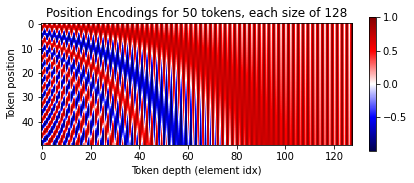

In [32]:
import math
from matplotlib import pyplot as plt

def generate_positional_encoding(num_tokens, dim_token):
    encodings = np.zeros((num_tokens, dim_token), dtype=float)
    pos = np.arange(num_tokens)
    div = 1e5 ** (np.arange(dim_token // 2) / dim_token)
    encodings[:, :: 2] = np.sin(pos[:, None] / div[None])
    encodings[:, 1:: 2] = np.cos(pos[:, None] / div[None])
    return encodings

_nt = 50
_dt = 128
pos_encodings = generate_positional_encoding(num_tokens=_nt, dim_token=_dt)

plt.imshow(pos_encodings, cmap='seismic')
plt.colorbar(fraction=0.02)
plt.title(f"Position Encodings for {_nt} tokens, each size of {_dt}")
plt.xlabel("Token depth (element idx)")
plt.ylabel("Token position")

### Почему positional encoding - такой "странный"? 

В attention вычисляются скалярные произведения токенов

$ \hat{emb} = emb + P_t$

$(\hat{emb}, \hat{emb}) = (emb + P_t, emb + P_t) = (emb, emb) + 2(emb, P_t) + (P_t, P_t)$


Text(0.5, 1.0, '(Pt, Pt) dot product')

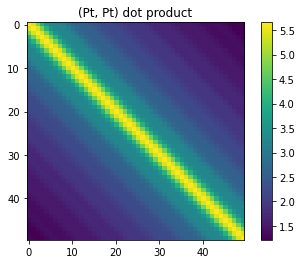

In [33]:
plt.imshow(
    pos_encodings @ pos_encodings.T / np.sqrt(_dt)
)
plt.colorbar()
plt.title("(Pt, Pt) dot product")

Text(0.5, 1.0, '(Pt, Pt) dot product')

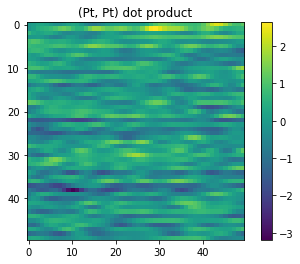

In [34]:
plt.imshow(
    np.random.randn(*pos_encodings.shape) @ pos_encodings.T / np.sqrt(_dt)
)
plt.colorbar()
plt.title("(Pt, Pt) dot product")

### Полезные ссылки
Formal Algorithms for Transformers: https://arxiv.org/pdf/2207.09238.pdf

- https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
- https://jalammar.github.io/illustrated-transformer/
- https://www.youtube.com/watch?v=U0s0f995w14
- https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html
- https://nlp.seas.harvard.edu/2018/04/03/attention.html